Set Up Environment

In [1]:
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.transform import rotate
from skimage.util import montage
import os
from sklearn.model_selection import train_test_split
import keras
import cv2
import tensorflow
import tensorflow as tf
import random
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import numpy as np
from keras.callbacks import CSVLogger
import keras.backend as K
import zipfile
import pandas as pd
from tensorflow.keras.utils import Sequence

ModuleNotFoundError: No module named 'skimage'

In [2]:
import os
print(os.listdir(r'D:\KULIAH\ITS\SEMESTER 7\Pengolahan Citra Biomedis\BRAts Dataset\Dataset Sementara'))


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:\\KULIAH\\ITS\\SEMESTER 7\\Pengolahan Citra Biomedis\\BRAts Dataset\\Dataset Sementara'

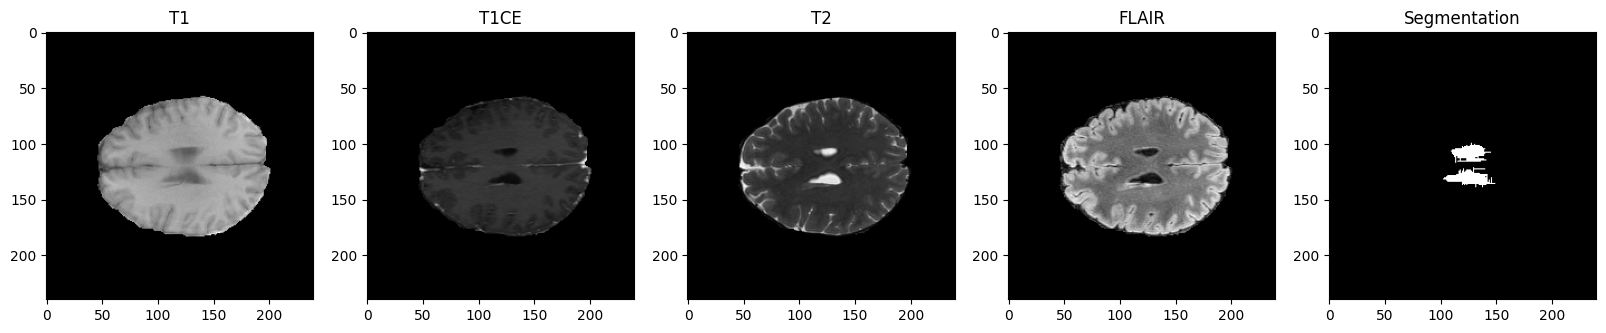

In [92]:
# Load the 4 MRI modalities and the segmentation located in the patient's path using the nibabel library
t1_img=nib.load ('D:\KULIAH\ITS\SEMESTER 7\Pengolahan Citra Biomedis\BRAts Dataset\Dataset Sementara\BraTS2021_00000\BraTS2021_00000_t1.nii.gz')
t1ce_img=nib.load ('D:\KULIAH\ITS\SEMESTER 7\Pengolahan Citra Biomedis\BRAts Dataset\Dataset Sementara\BraTS2021_00000\BraTS2021_00000_t1ce.nii.gz')
t2_img=nib.load ('D:\KULIAH\ITS\SEMESTER 7\Pengolahan Citra Biomedis\BRAts Dataset\Dataset Sementara\BraTS2021_00000\BraTS2021_00000_t2.nii.gz')
flair_img=nib.load ('D:\KULIAH\ITS\SEMESTER 7\Pengolahan Citra Biomedis\BRAts Dataset\Dataset Sementara\BraTS2021_00000\BraTS2021_00000_flair.nii.gz')
seg_img=nib.load ('D:\KULIAH\ITS\SEMESTER 7\Pengolahan Citra Biomedis\BRAts Dataset\Dataset Sementara\BraTS2021_00000\BraTS2021_00000_seg.nii')

# Get the image data
t1_data = t1_img.get_fdata()
t1ce_data = t1ce_img.get_fdata()
t2_data = t2_img.get_fdata()
flair_data = flair_img.get_fdata()
seg_data = seg_img.get_fdata()

# Plot the 100th slice of the 4 RMI modalities and the segmentation
slice_nb = 100

fig, axs = plt.subplots(1, 5, figsize=(20,20))
axs[0].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs[0].set_title('T1')
axs[1].imshow(t1ce_data[:,:,slice_nb], cmap="gray")
axs[1].set_title('T1CE')
axs[2].imshow(t2_data[:,:,slice_nb], cmap="gray")
axs[2].set_title('T2')
axs[3].imshow(flair_data[:,:,slice_nb], cmap="gray")
axs[3].set_title('FLAIR')
axs[4].imshow(seg_data[:,:,slice_nb], cmap="gray")
axs[4].set_title('Segmentation')
plt.show()

In [23]:
# Modality shape
print(t1_data.shape)

# Segmentation shape
print(seg_data.shape)

(240, 240, 155)
(240, 240, 155)


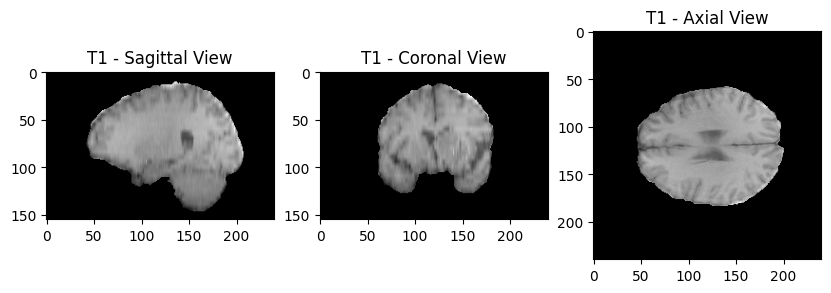

In [24]:
# Plot a RMI modality through all planes
slice_nb = 100

fig, axs2 = plt.subplots(1, 3, figsize=(10,10))

# Apply a 90Â° rotation with an automatic resizing, otherwise the display is less obvious to analyze
axs2[0].imshow(rotate(t1_data[slice_nb,:,:], 90, resize=True), cmap="gray")
axs2[0].set_title('T1 - Sagittal View')

axs2[1].imshow(rotate(t1_data[:,slice_nb,:], 90, resize=True), cmap="gray")
axs2[1].set_title('T1 - Coronal View')

axs2[2].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs2[2].set_title('T1 - Axial View')

plt.show()

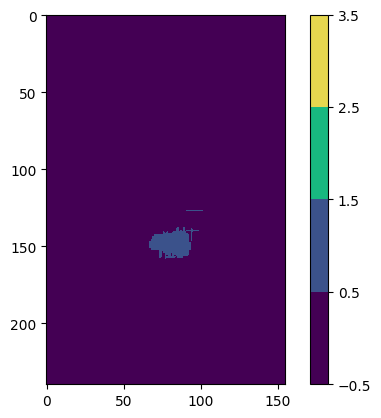

In [25]:
# Plot a segmantation
some_seg_img = nib.load("D:\KULIAH\ITS\SEMESTER 7\Pengolahan Citra Biomedis\BRAts Dataset\Dataset Sementara\BraTS2021_00000\BraTS2021_00000_seg.nii").get_fdata()

cmap = mpl.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

plt.imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
plt.colorbar()

In [93]:
data_path = "D:\KULIAH\ITS\SEMESTER 7\Pengolahan Citra Biomedis\BRAts Dataset\Dataset Sementara"
seg_samples = [os.path.join(data_path, sample, f"{sample}_seg.nii") for sample in os.listdir(data_path) if not sample.endswith('.csv')]

saved_values = []
max_nb_values = 0
for sample in seg_samples:
    seg_img = nib.load(sample).get_fdata()
    unique_values = np.unique(seg_img)
    nb_unique_values = len(np.unique(seg_img))

    if nb_unique_values > max_nb_values:
        max_nb_values = nb_unique_values
        saved_values = unique_values

print(f"Maximum number of values in all segmentation images: {max_nb_values}")
print(f"Values: {saved_values}")

Maximum number of values in all segmentation images: 2
Values: [0. 1.]


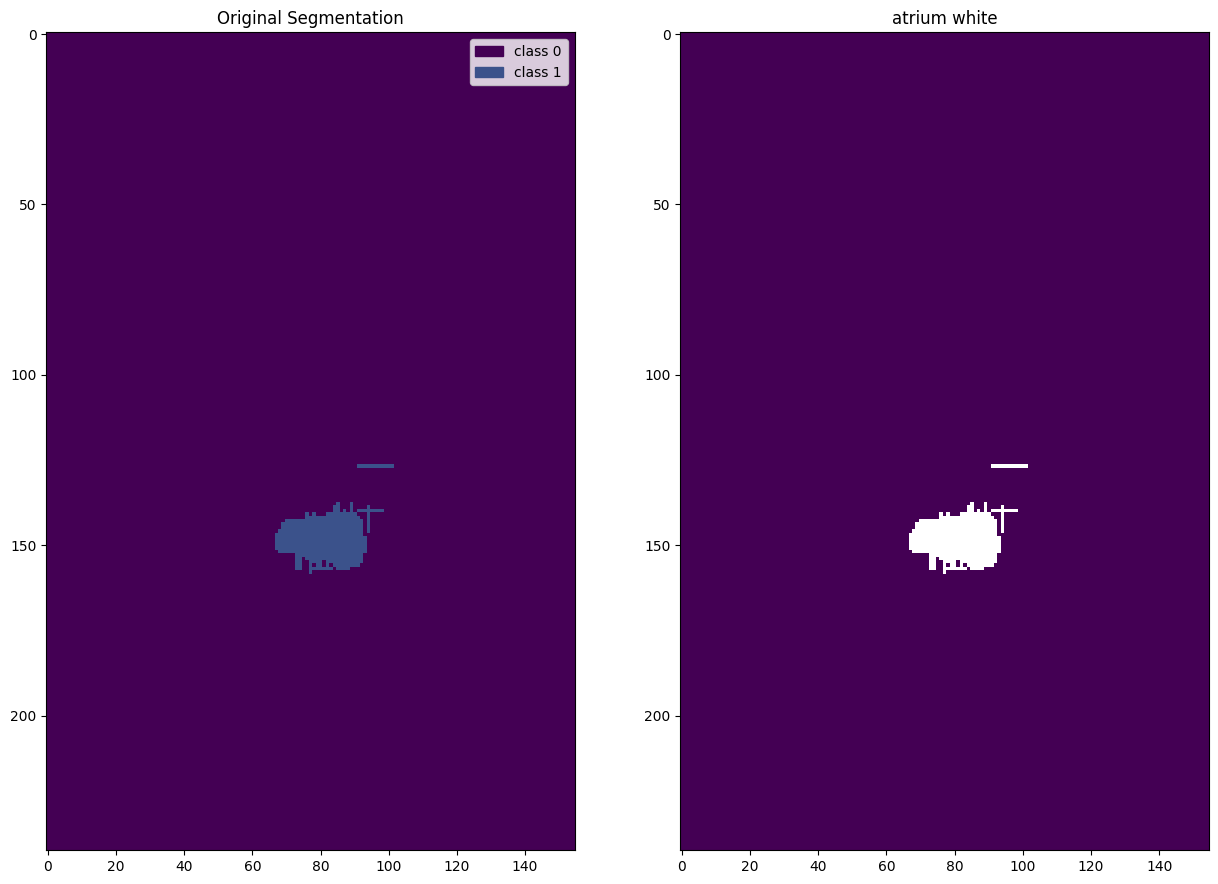

In [94]:
# Deletion of class 0
seg_0 = some_seg_img.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = some_seg_img.copy()
seg_1[seg_1 != 1] = np.nan

# Define legend
class_names = ['class 0', 'class 1']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, axs3 = plt.subplots(1, 2, figsize=(15, 15))

axs3[0].imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
axs3[0].set_title('Original Segmentation')
axs3[0].legend(handles=legend, loc='upper right')

axs3[1].imshow(seg_0[100,:,:], cmap=cmap, norm=norm)
axs3[1].set_title('atrium white')

plt.show()

In [95]:
# Define selected slices range
VOLUME_START_AT = 60
VOLUME_SLICES = 75

In [99]:
# Specify path of our BraTS2020 directory
data_path = "D:\KULIAH\ITS\SEMESTER 7\Pengolahan Citra Biomedis\BRAts Dataset\Dataset Sementara"

# Retrieve all samples from path with listdir(). This method lists of all files + directories in the specified directory.
samples = os.listdir(data_path)
print("Number of samples:", len(samples))

Number of samples: 90


In [98]:
# Split the dataset into train and validation sets
samples_train, samples_val = train_test_split(samples, test_size=0.2, random_state=42)

# Split the train set into the real train set and in a test set
samples_train, samples_test = train_test_split(samples_train, test_size=0.15, random_state=42)

# Print data distribution (Train: 68%, Test: 20%, Val: 11.11%)
print(f"Train length: {len(samples_train)}")
print(f"Validation length: {len(samples_val)}")
print(f"Test length: {len(samples_test)}")

Train length: 61
Validation length: 18
Test length: 11


In [100]:
IMG_SIZE = 128

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, t1ce_paths, flair_paths, seg_paths, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.t1ce_paths = t1ce_paths
        self.flair_paths = flair_paths
        self.seg_paths = seg_paths
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.t1ce_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        t1ce_batch_paths = [self.t1ce_paths[k] for k in indexes]
        flair_batch_paths = [self.flair_paths[k] for k in indexes]
        seg_batch_paths = [self.seg_paths[k] for k in indexes]
        X, y = self.__data_generation(t1ce_batch_paths, flair_batch_paths, seg_batch_paths)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.t1ce_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, t1ce_batch_paths, flair_batch_paths, seg_batch_paths):
        'Generates data containing batch_size samples' 
        num_classes = 2  # For binary segmentation
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, num_classes))

        for i in range(len(t1ce_batch_paths)):
            t1ce = nib.load(t1ce_batch_paths[i]).get_fdata()
            flair = nib.load(flair_batch_paths[i]).get_fdata()
            seg = nib.load(seg_batch_paths[i]).get_fdata()
            
            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * i, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], self.dim)
                X[j + VOLUME_SLICES * i, :, :, 1] = cv2.resize(t1ce[:, :, j + VOLUME_START_AT], self.dim)
                seg_resized = cv2.resize(seg[:, :, j + VOLUME_START_AT], self.dim, interpolation=cv2.INTER_NEAREST)
                y[j + VOLUME_SLICES * i] = tensorflow.one_hot(seg_resized, num_classes)

        return X / np.max(X), y


# Example patient IDs for training, validation, and testing
# All available patient IDs
all_patient_ids = [f"{i:02d}" for i in range(96) if i in [0, 2, 3, 5, 6, 8, 9, 11, 12, 14, 16, 17, 18, 19, 20, 21] + list(range(22, 96))]

# Splitting into train, validation, and test
train_ids = all_patient_ids[:61]
validation_ids = all_patient_ids[61:61+18]
test_ids = all_patient_ids[61+18:]

# Assuming the file structure follows a consistent pattern  # Replace with your actual base path

base_path = 'D:\KULIAH\ITS\SEMESTER 7\Pengolahan Citra Biomedis\BRAts Dataset\Dataset Sementara'

def generate_full_paths(base_path, sample_list):
    t1ce_paths = [f"{base_path}/BraTS2021_{sample_id.zfill(5)}/BraTS2021_{sample_id.zfill(5)}_t1ce.nii.gz" for sample_id in sample_list]
    flair_paths = [f"{base_path}/BraTS2021_{sample_id.zfill(5)}/BraTS2021_{sample_id.zfill(5)}_flair.nii.gz" for sample_id in sample_list]
    seg_paths = [f"{base_path}/BraTS2021_{sample_id.zfill(5)}/BraTS2021_{sample_id.zfill(5)}_seg.nii" for sample_id in sample_list]
    return t1ce_paths, flair_paths, seg_paths

# Now you can generate the full paths with the correct patient ids
t1ce_paths_train, flair_paths_train, seg_paths_train = generate_full_paths(base_path, train_ids)
t1ce_paths_val, flair_paths_val, seg_paths_val = generate_full_paths(base_path, validation_ids)
t1ce_paths_test, flair_paths_test, seg_paths_test = generate_full_paths(base_path, test_ids)

training_generator = DataGenerator(t1ce_paths_train, flair_paths_train, seg_paths_train)
valid_generator = DataGenerator(t1ce_paths_val, flair_paths_val, seg_paths_val)
test_generator = DataGenerator(t1ce_paths_test, flair_paths_test, seg_paths_test)


# Now you can use these generators with model.fit


In [101]:
# U-Net implementation for BraTS 2019 by Naomi Fridman, https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(2, 1, activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

In [102]:
# Compute metric between the predicted segmentation and the ground truth
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 2
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,i])
        y_pred_f = K.flatten(y_pred[:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [103]:
# Define input data shape
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# Build and compile the model
model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tensorflow.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity] )

In [104]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),

    keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
                             verbose=1, save_best_only=True, save_weights_only = True),

    CSVLogger('training.log', separator=',', append=False)
]

In [105]:
model.fit(training_generator,
          epochs=35,
          steps_per_epoch=len(samples_train),
          callbacks=callbacks,
          validation_data=valid_generator)

Epoch 1/35
61/61 [==============================] - ETA: 0s - loss: 0.0599 - accuracy: 0.9809 - mean_io_u_3: 0.6333 - dice_coef: 0.9646 - precision: 0.9809 - sensitivity: 0.9809 - specificity: 0.9809
Epoch 1: val_loss improved from inf to 0.02871, saving model to model_.01-0.028707.m5
61/61 [==============================] - 205s 3s/step - loss: 0.0599 - accuracy: 0.9809 - mean_io_u_3: 0.6333 - dice_coef: 0.9646 - precision: 0.9809 - sensitivity: 0.9809 - specificity: 0.9809 - val_loss: 0.0287 - val_accuracy: 0.9898 - val_mean_io_u_3: 0.6779 - val_dice_coef: 0.9987 - val_precision: 0.9898 - val_sensitivity: 0.9898 - val_specificity: 0.9898 - lr: 0.0010
Epoch 2/35
61/61 [==============================] - ETA: 0s - loss: 0.0296 - accuracy: 0.9900 - mean_io_u_3: 0.7498 - dice_coef: 0.9996 - precision: 0.9900 - sensitivity: 0.9900 - specificity: 0.9900
Epoch 2: val_loss did not improve from 0.02871
61/61 [==============================] - 208s 3s/step - loss: 0.0296 - accuracy: 0.9900 - me

In [113]:
predictions = model.predict(test_generator)

# Assuming binary segmentation, convert predictions to 2D
# This step extracts the most likely class for each pixel and then reshapes the array
predicted_classes = np.argmax(predictions, axis=-1)  # Most likely class for each pixel
flattened_predictions = predicted_classes.reshape(-1)  # Flatten the 2D array into 1D

11/11 [==============================] - 14s 1s/step


In [116]:
history = pd.read_csv('training.log', sep=',', engine='python')
print(history.columns)


Index(['epoch', 'accuracy', 'dice_coef', 'loss', 'lr', 'mean_io_u_3',
       'precision', 'sensitivity', 'specificity', 'val_accuracy',
       'val_dice_coef', 'val_loss', 'val_mean_io_u_3', 'val_precision',
       'val_sensitivity', 'val_specificity'],
      dtype='object')


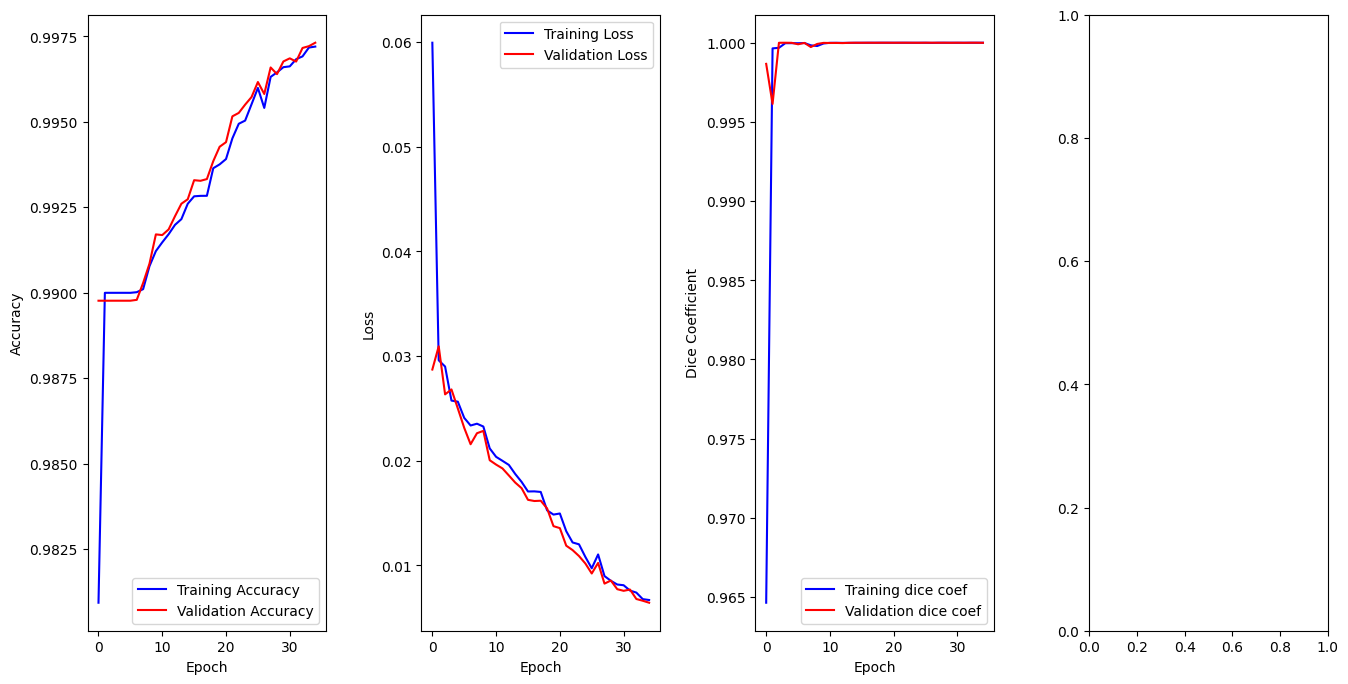

In [120]:
# Read the CSVlogger file that contains all our metrics (accuracy, loss, dice_coef, ...) of our training
history = pd.read_csv('training.log', sep=',', engine='python')

# Plot training and validation metrics
fig, axs = plt.subplots(1, 4, figsize=(16, 8))

axs[0].plot(history['epoch'], history['accuracy'], 'b', label='Training Accuracy')
axs[0].plot(history['epoch'], history['val_accuracy'], 'r', label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(history['epoch'], history['loss'], 'b', label='Training Loss')
axs[1].plot(history['epoch'], history['val_loss'], 'r', label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

axs[2].plot(history['epoch'], history['dice_coef'], 'b', label='Training dice coef')
axs[2].plot(history['epoch'], history['val_dice_coef'], 'r', label='Validation dice coef')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Dice Coefficient')
axs[2].legend()

# Add space between subplots
plt.subplots_adjust(wspace=0.4)

plt.show()

In [121]:
# Evaluate the model on the test data

results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)

descriptions = ["Loss", "Accuracy", "MeanIOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity"]

# Combine results list and descriptions list
results_list = zip(results, descriptions)

# Display each metric with its description
print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

11/11 [==============================] - 15s 1s/step - loss: 0.0062 - accuracy: 0.9974 - mean_io_u_3: 0.8814 - dice_coef: 1.0000 - precision: 0.9974 - sensitivity: 0.9974 - specificity: 0.9974

Model evaluation on the test set:
Loss : 0.0062
Accuracy : 0.9974
MeanIOU : 0.8814
Dice coefficient : 1.0
Precision : 0.9974
Sensitivity : 0.9974
Specificity : 0.9974


In [122]:
def predict_segmentation(sample_path):
    t1ce_img = nib.load('D:\\KULIAH\\ITS\\SEMESTER 7\\Pengolahan Citra Biomedis\\BRAts Dataset\\Dataset Sementara\\BraTS2021_00000\\BraTS2021_00000_t1ce.nii.gz')
    flair_img = nib.load('D:\\KULIAH\\ITS\\SEMESTER 7\\Pengolahan Citra Biomedis\\BRAts Dataset\\Dataset Sementara\\BraTS2021_00000\\BraTS2021_00000_flair.nii.gz')

    # Get the image data
    t1ce_data = t1ce_img.get_fdata()
    flair_data = flair_img.get_fdata()

    # Create an empty array
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
        
        # Perform the same operations as our DataGenerator, to keep the same input shape
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair_data[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce_data[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

        # Send our images to the CNN model and return predicted segmentation 
    X_normalized = X / np.max(X) 

    predictions = model.predict(X_normalized, verbose=1)
    return predictions


In [130]:
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm):
    # Choose a random patient
    random_sample = random.choice(samples_list)
    
    # Get path of this patient
    random_sample_path = os.path.join(data_path, random_sample, random_sample)
    
    # Predict patient's segmentation
    predicted_seg = predict_segmentation(random_sample_path)
   
    # Load patient's original segmentation (Ground truth)
    seg_path = random_sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()
    
    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    
    # Differentiate segmentations by their labels
    all = predicted_seg[slice_to_plot,:,1:4] # Deletion of class 0 (Keep only Core + Edema + Enhancing classes)
    zero = predicted_seg[slice_to_plot,:,0] # Isolation of class 0, Background (kind of useless, it is the opposite of the "all")
    first = predicted_seg[slice_to_plot,:,:,1] # Isolation of class 1, Core
    # Plot Original segmentation & predicted segmentation
    print("Patient number: ", random_sample)
    fig, axstest = plt.subplots(1, 6, figsize=(25, 20))

    # Original segmentation
    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')
    
    # Layer 0
    axstest[2].imshow(zero)
    axstest[2].set_title('Predicted Segmentation - layer 0')
    
    # Layer 1
    axstest[3].imshow(first)
    axstest[3].set_title('Predicted Segmentation - layer 1')
    
    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)

    plt.show()

3/3 [==============================] - 1s 330ms/step
Patient number:  BraTS2021_00014


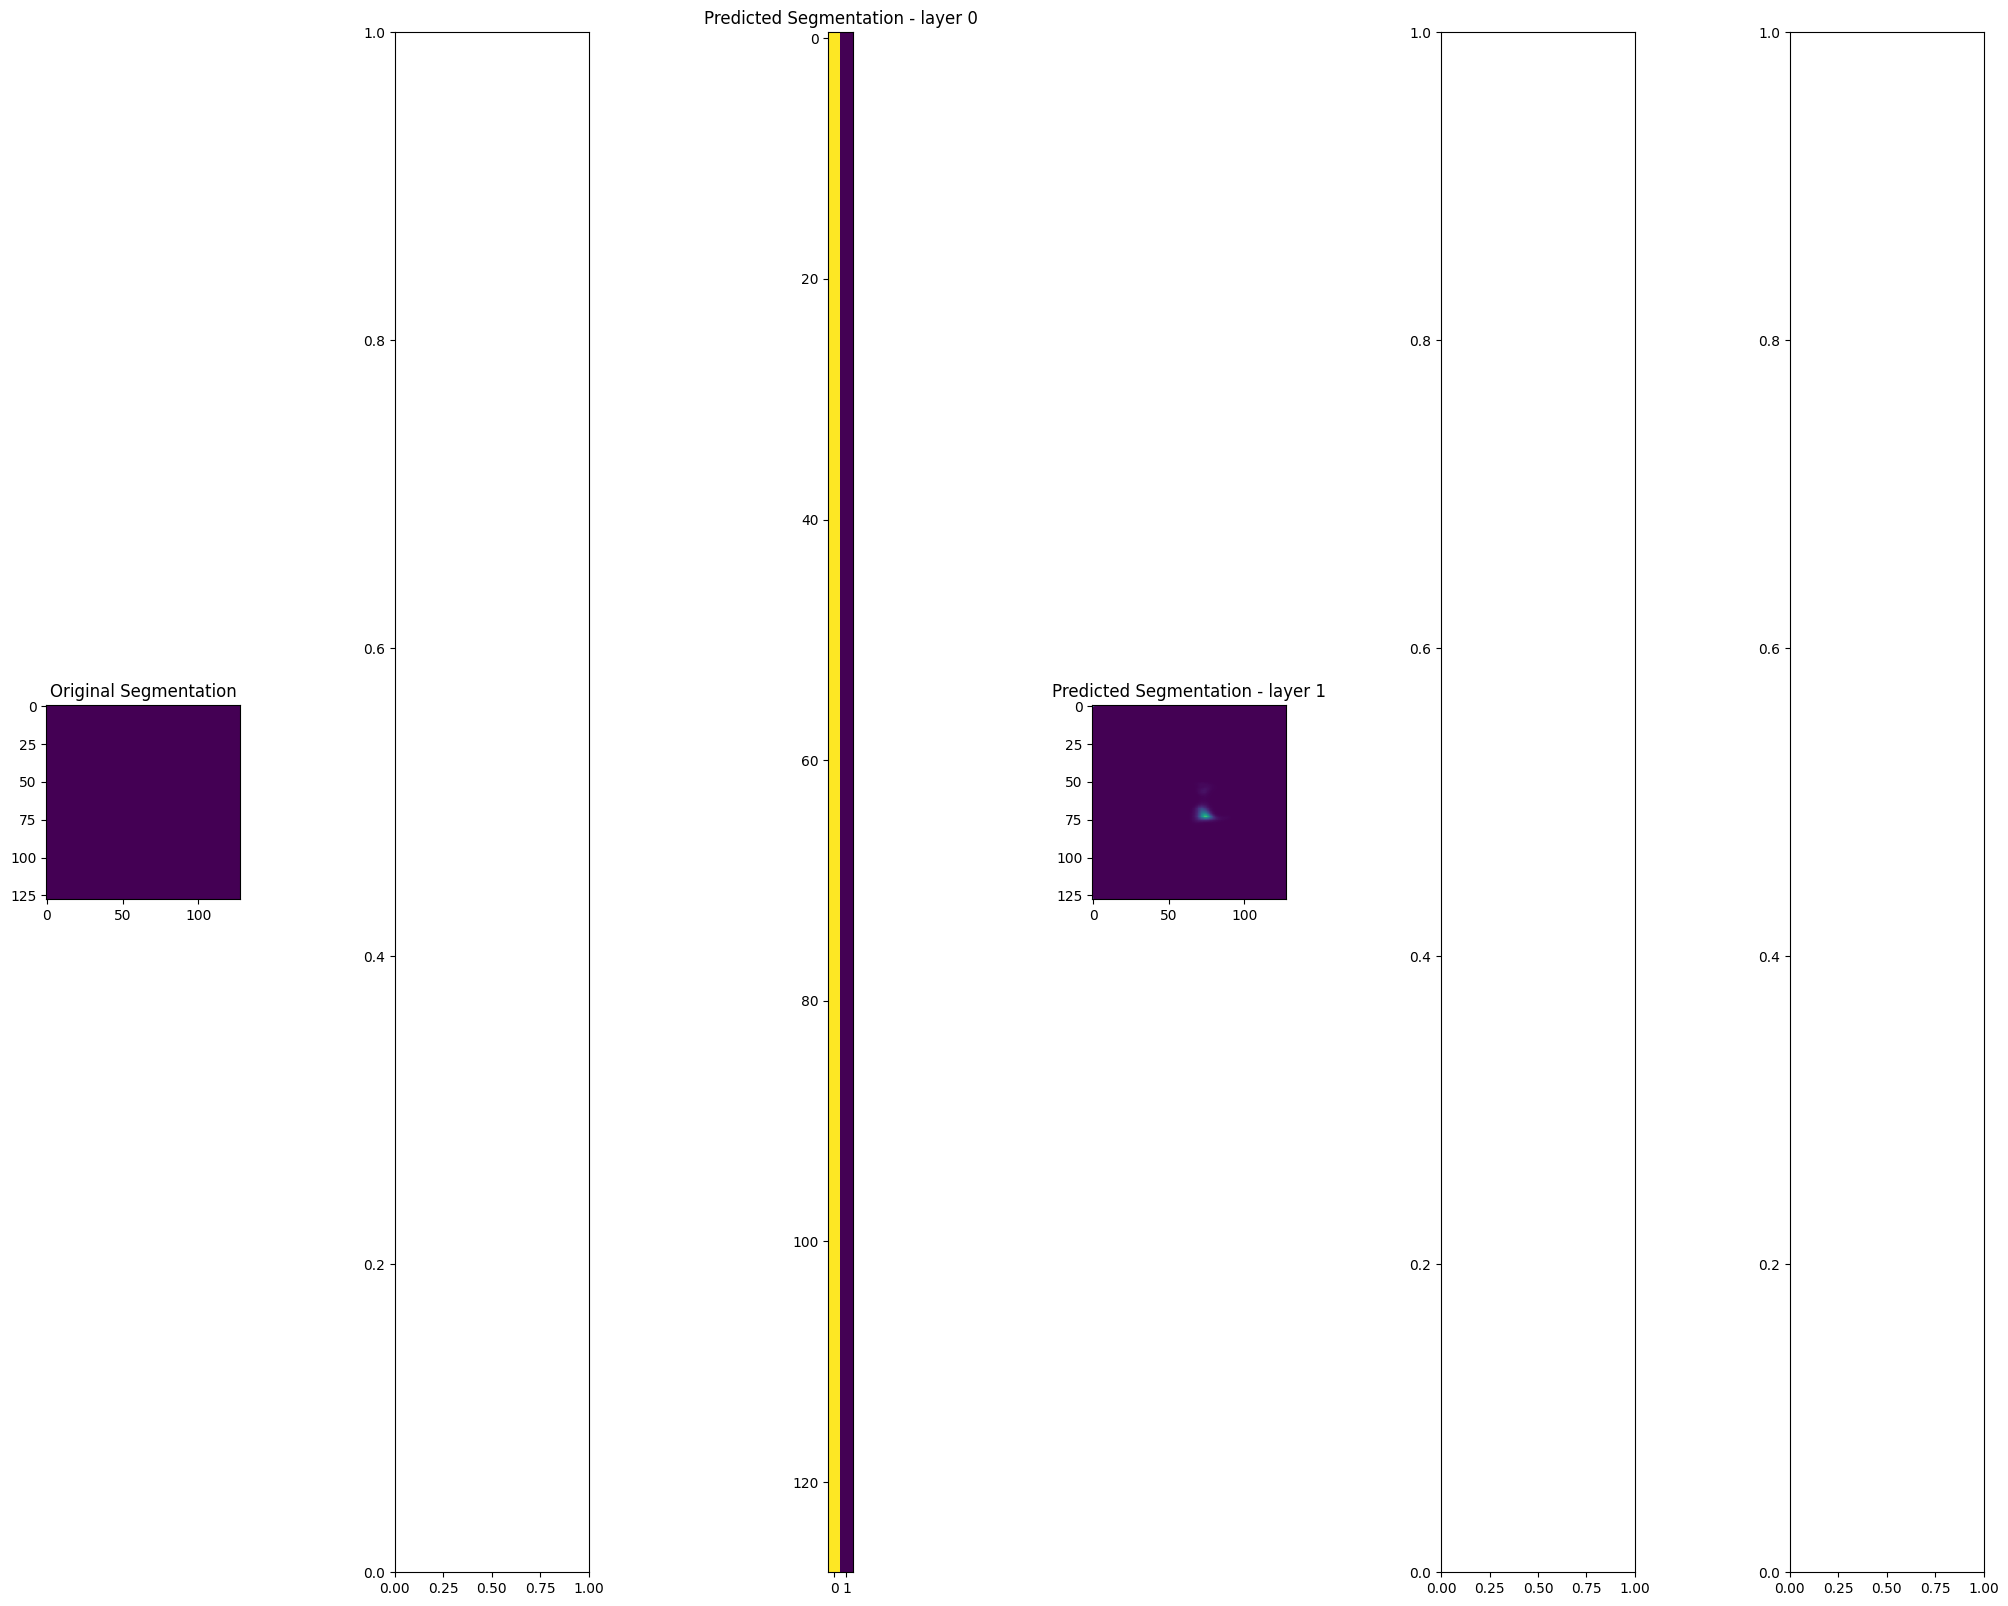

In [132]:
show_predicted_segmentations(samples_test, 60, cmap, norm)

In [133]:
def show_post_processed_segmentations(sample, slice_to_plot, cmap, norm):
    
    # Get path of this patient
    sample_path = os.path.join(data_path, sample, sample)
    
    # Predict patient's segmentation
    predicted_seg = predict_segmentation(sample_path)
   
    # Load patient's original segmentation (Ground truth)
    seg_path = sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()
    
    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    
    # Fix 4 to 3 to have the same values as in the predicted segmentation, and then same colors
    seg[seg==4] = 3
    
    # Remove background layer (0) from original segmentation
    seg[seg==0] = np.nan
    
    # Post-processing
    # Get indexes for each class of the highest probability pixels. Array will then contain only [0 1 2 3] instead of probabilities
    my_pred = np.argmax(predicted_seg, axis=3)
    my_pred = my_pred[slice_to_plot, :, :]

    # Remove background layer (0) from post-processed predicted segmentation
    # To fix 0 to np.nan, we need to convert array as a float
    my_pred = my_pred.astype(float)
    my_pred[my_pred == 0] = np.nan

    # Remove background layer (0) from classical predicted segmentation
    all = predicted_seg[slice_to_plot,:,:,1:4] 
    
    # Plot Original segmentation & predicted segmentation without processing & predicted segmentation
    print("Patient number: ", sample)
    fig, axstest = plt.subplots(1, 3, figsize=(15, 10))

    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')
    
    axstest[1].imshow(all)
    axstest[1].set_title('Prediction (w/o post processing (layer 1,2,3)')
    
    axstest[2].imshow(my_pred, cmap, norm)
    axstest[2].set_title('Prediction (w/ post processing (layer 1,2,3)')
    
    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)
    
    plt.show()

In [135]:
show_post_processed_segmentations(sample = "BraTS20_Training_266", slice_to_plot=60, cmap=cmap, norm=norm)

3/3 [==============================] - 1s 349ms/step


FileNotFoundError: No such file or no access: 'D:\KULIAH\ITS\SEMESTER 7\Pengolahan Citra Biomedis\BRAts Dataset\Dataset Sementara\BraTS2021_00003_seg.nii'